In [17]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [18]:
#constants / QuadCopter dimensions
g = 9.81 # gravity
k = 6.36105*10**-9  # propellar lift coefficient
b = 4.65133*10**-11  # drag coefficient

m_body = 0.7
l_body = 0.5
w_body = l_body
t_body = 0.1

m_arm = 0.05
l_arm = 0.4

l_rz = 0.05
#1 # z-distance between rotors and center of mass

In [19]:
def body_forces(w1, w2, w3, w4):
    taux = l_rz * k * (-w2**2 + w4**2)
    tauy = l_rz * k * (-w1**2 + w3**2)
    tauz = l_rz * b * (w1**2 - w2**2 + w3**2 - w4**2)

    fz = k * (w1**2 + w2**2 + w3**2 + w4**2)

    return taux, tauy, tauz, fz

In [20]:
#calcs moments of inertia 
m = 4*m_arm + m_body

I_xx_body = 1/12 * m_body*(w_body**2 + t_body**2)
I_yy_body = 1/12 * m_body*(l_body**2 + t_body**2)
I_zz_body = 1/12 * m_body *(w_body**2 + l_body**2)

I_xx_arm = 1/12 * m_arm * l_arm**2 + m_arm * (l_arm/2 + l_body/2)**2
I_yy_arm = 1/12 * m_arm * l_arm**2 + m_arm * (l_arm/2 + l_body/2)**2
I_zz_arm = I_yy_arm

Ixx = 2*I_xx_arm + I_xx_body
Iyy = 2*I_yy_arm + I_yy_body
Izz = 4*I_zz_arm + I_zz_body
Izz


0.07233333333333333

In [21]:
def quad_EOM(t, q, taux, tauy, tauz, fz):

    #must be first-order ODES
    '''
    Arguements:
        q : state vector :
        [px, py, pz, vx, vy, vz, phi, theta, psi, 
        omegax, omegay, omegaz, taux, tauy, tauz, fz]

        t : time
        p : various vector parameters : 
        [m, Ixx, Iyy, Izz]
    '''

    px, py, pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz = q

    C_phi = np.cos(phi)
    C_theta = np.cos(theta)
    C_psi = np.cos(psi)
    
    S_phi = np.sin(phi)
    S_theta = np.sin(theta)
    S_psi = np.sin(psi)


    px_dot = vx*C_psi*C_theta + vy*(S_phi*S_theta*C_psi - S_psi * C_phi) + vz * (S_phi * S_psi + S_theta*C_phi*C_psi)
    py_dot = vx*S_psi*C_theta + vy*(S_phi * S_psi * S_theta + C_phi * C_psi) - vz*(S_phi * C_psi - S_psi * S_theta * C_phi)
    pz_dot = -vx*S_theta + vy*S_phi*C_theta + vz * C_phi * C_theta

    vx_dot = -omegay*vz + omegaz*vy + g*S_theta
    vy_dot = omegax*vz - omegaz*vx - g*S_phi*C_theta
    vz_dot = fz/m - omegax*vy + omegay*vx - g*C_phi*C_theta

    phi_dot = omegax + omegay*S_phi*S_theta/C_theta + omegaz*C_phi*S_theta/C_theta
    theta_dot = omegay*C_phi - omegaz*S_phi
    psi_dot = 1/C_theta * (omegay*S_phi + omegaz*C_phi)

    omegax_dot = 1/Ixx * (Iyy*omegay*omegaz - Izz*omegay*omegaz + taux)
    omegay_dot = 1/Iyy * (-Ixx*omegax*omegaz + Izz*omegax * omegaz + tauy)
    omegaz_dot = 1/Izz * (Ixx*omegax*omegay - Iyy*omegax*omegay + tauz)



    EOM = [px_dot, py_dot, pz_dot, 
           vx_dot, vy_dot, vz_dot,
           phi_dot, theta_dot, psi_dot,
           omegax_dot, omegay_dot, omegaz_dot]

    return EOM 

In [22]:
#caclulates intial conditions
r = 2
ang = 0.5/2
theta_init = -np.arctan(r*ang**2/g)

Thrust = m*g / np.cos(theta_init)
w = np.sqrt(Thrust/(4*k))
Thrust


wx0 = ang*np.sin(-theta_init)
wz0 = ang*np.cos(-theta_init)
tauy = Ixx*wx0*wz0 - Izz*wx0*wz0

In [23]:
#used to find propeller RPMs
w1, w2, w3, w4 = symbols('omega_1, omega_2, omega_3, omega_4')
taux = Eq(l_rz * k * (-w2**2 + w4**2), 0)
tauy = Eq(l_rz * k * (-w1**2 + w3**2), -2.8333299026588865e-05)
tauz = Eq(l_rz * b * (w1**2 - w2**2 + w3**2 - w4**2), 0)
fz = Eq(k * (w1**2 + w2**2 + w3**2 + w4**2), 8.829716714028825)

soln =solve((taux, tauy, tauz, fz), (w1, w2, w3, w4))

In [24]:
#propeller controls
#W = 8.828999999999999
#w = 18627.79106464644
    #clockwise
w1 = 18629.7426143704
w3 = 18627.3515605492
    #counter-clockwise
w2 = 18628.5471258225
w4 = 18628.5471258225


fr = body_forces(w1, w2, w3, w4)

In [25]:
px0 = 2
py0 = 0
pz0 = 1
vx0 = 0.
vy0 = 0.5
vz0 = 0
phi0 = 0
theta0 = theta_init
psi0 = 0
omegax0 = 0.25*np.sin(-theta_init)
omegay0 = 0
omegaz0 = 0.25*np.cos(-theta_init)


t = (0, 60)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)


para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.01, args = para)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.166e-03 ...  5.999e+01  6.000e+01]
        y: [[ 2.000e+00  2.000e+00 ... -1.517e+00 -1.519e+00]
            [ 0.000e+00  2.083e-03 ...  1.303e+00  1.301e+00]
            ...
            [ 0.000e+00  2.396e-17 ...  2.203e-14  2.201e-14]
            [ 2.500e-01  2.500e-01 ...  2.500e-01  2.500e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 36008
     njev: 0
      nlu: 0

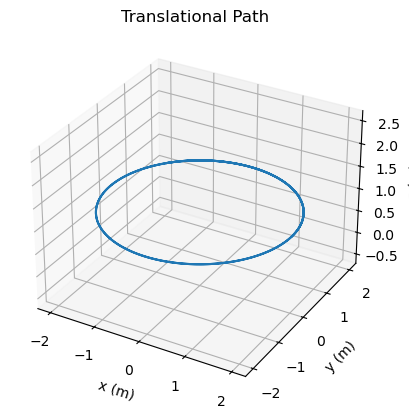

In [26]:
fig = plt.figure()
pax = fig.add_subplot(111, projection='3d')

pax.plot(sol.y[0], sol.y[1], sol.y[2])
pax.axis('equal')

pax.set_title('Translational Path')
pax.set_xlabel('x (m)')
pax.set_ylabel('y (m)')
pax.set_zlabel('z (m)')
fig.savefig(fname = 'circle_path', dpi = 1200)
plt.show()

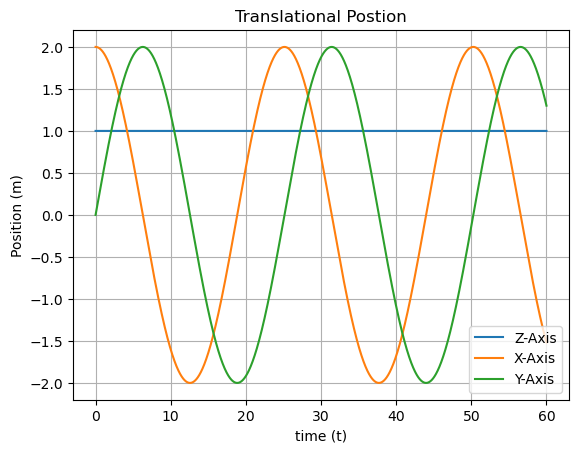

In [27]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[2], label = 'Z-Axis')
pax.plot(sol.t, sol.y[0], label = 'X-Axis')
pax.plot(sol.t, sol.y[1], label = 'Y-Axis')

pax.set_title('Translational Postion')
pax.set_xlabel('time (t)')
pax.set_ylabel('Position (m)')
pax.grid()
pax.legend()
fig.savefig(fname = 'circle_trans', dpi = 1200)
plt.show()

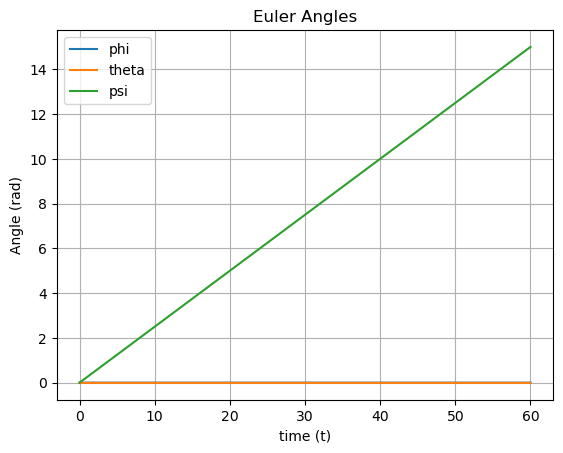

In [28]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[6], label = 'phi')
pax.plot(sol.t, sol.y[7], label = 'theta')
pax.plot(sol.t, sol.y[8], label = 'psi')

pax.set_title('Euler Angles')
pax.set_xlabel('time (t)')
pax.set_ylabel('Angle (rad)')
pax.grid()
pax.legend()
fig.savefig(fname = 'circle_euler', dpi = 1200)
plt.show()

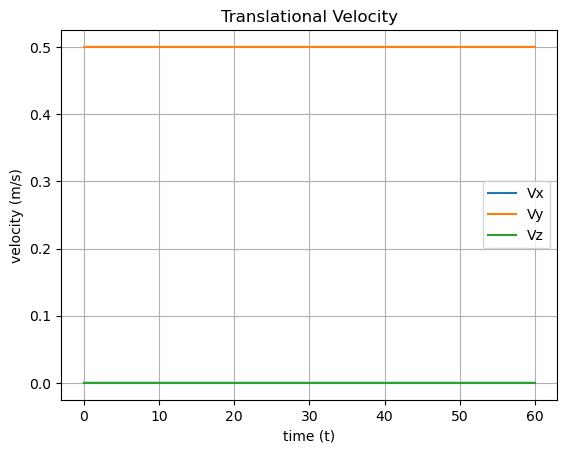

In [29]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[3], label = 'Vx')
pax.plot(sol.t, sol.y[4], label = 'Vy')
pax.plot(sol.t, sol.y[5], label = 'Vz')

pax.set_title('Translational Velocity')
pax.set_xlabel('time (t)')
pax.set_ylabel('velocity (m/s)')
pax.grid()
pax.legend()
fig.savefig(fname = 'circle_vel', dpi = 1200)
plt.show()

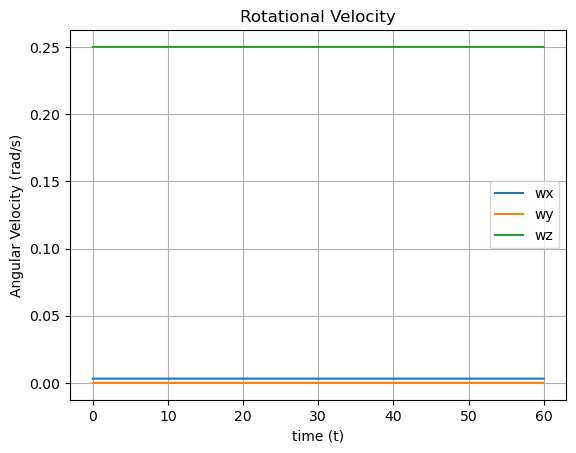

In [30]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[9], label = 'wx')
pax.plot(sol.t, sol.y[10], label = 'wy')
pax.plot(sol.t, sol.y[11], label = 'wz')

pax.set_title('Rotational Velocity')
pax.set_xlabel('time (t)')
pax.set_ylabel('Angular Velocity (rad/s)')
pax.grid()
pax.legend()
fig.savefig(fname = 'circle_w', dpi = 1200)
plt.show()